<a href="https://colab.research.google.com/github/juniaufmg/analise_dados_saude_ceara/blob/main/Modelos_dadoCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

Primeiramente é necessário a preparação do ambiente para os experimentos. Instala-se a biblioteca scikit-learn e depois carrega-se o Dataset.

In [ ]:
import sys
! pip install scikit-learn
import scipy

#importando csv no drive. Acesso por e-mail é necessario
import pandas as pd
import numpy as np
#from google.colab import drive
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

#drive.mount('/content/drive')

#importando os dados para a atividade
url = "https://raw.githubusercontent.com/EscolaDeSaudePublica/teste-momento2-edital-ciencia-de-dados/main/dataset_teste_selecao.csv"
#url.read().decode('UTF8', 'replace')
df =  pd.read_csv(url,  encoding='latin1' )


df.head()

,paciente_id,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,tabagismo,drogas,etilismo,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,paciente_chegou_com_suporte_respiratorio,vmi,uti,necessidade_transfusional,fenomenos_tromboembolicos_tvp,fenomenos_tromboembolicos_tep,sepse,disfuncao_hepatica,choque_septico,disfuncao_multipla_de_orgaos,choque_hipovolemico,complicacao_neurologica,hemorragia,hemodialise,tempo_vmi_total,tempo_uti_total,tempo_internacao,tempo_referencia_internacao,nomemacro,bairro,latitude,longitude,idh_label,sexo,idade,cor_autorreferida,estado_civil,escolaridade,tipo_caso_à_admissão,tempo_sintomas_internacao,desfecho,obito_menos24horas,obito_vm,obito_uti
0,e5841df2166dd424a57127423d276bbe,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Sim,Não,Sim,Não,Não,Não,Não,Sim,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,15.0,11.0,11.0,4.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Feminino,76.0,Parda/mulata,Casado/ amasiado,Ensino fundamental incompleto(1ºG),Caso suspeito,NaN,obito,Não,Sim,Sim
1,3c59dc048e8850243be8079a5c74d079,Não,Sim,Não,Sim,Sim,Não,Não,Sim,Não,Sim,Não,Não,Sim,Não,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Sim,Sim,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,29.0,32.0,37.0,3.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Masculino,33.0,Não informado,Não informado,Não informado,Caso suspeito,7.0,alta,NaN,NaN,NaN
2,99c5e07b4d5de9d18c350cdf64c5aa3d,Não,Não,Não,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Sim,Não,Sim,Não,Não,Não,Não,Não,Sim,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Sim,28.0,31.0,37.0,4.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Masculino,42.0,Amarela/Oriental,Casado/ amasiado,Ensino médio completo,Caso suspeito,10.0,alta,NaN,NaN,NaN
3,1587965fb4d4b5afe8428a4a024feb0d,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Sim,Sim,Não,Não,Não,Sim,Não,Não,Não,Não,Sim,Não,Sim,40.0,34.0,34.0,1.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Feminino,64.0,Branca,Casado/ amasiado,Ensino fundamental incompleto(1ºG),Caso suspeito,11.0,obito,Não,Sim,Sim
4,b4a528955b84f584974e92d025a75d1f,Não,Não,Não,Não,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Sim,Sim,Não,Não,Não,Não,Não,Sim,Sim,Sim,Sim,Não,Não,Não,Não,Não,Não,Não,Não,Sim,Sim,Não,12.0,21.0,33.0,0.0,MACRORREGIÃO DE SAÚDE - SERTÃO CENTRAL,NaN,NaN,NaN,NaN,Masculino,73.0,Parda/mulata,Casado/ amasiado,Ensino fundamental incompleto(1ºG),Caso suspeito,7.0,obito,Não,Sim,Sim


# **Pré Processamento**

Antes de iniciar os experimentos realiza-se o processamento de dados.


1.   Primeiro troca-se a tag 'CONFIRMED' para 1 e 'FASE POSITIVE' para 0;
2.   Depois apaga-se a coluna 'kepoi_name', pois a coluna de nome não é relevante para os experimentos.



In [ ]:
df = df.replace('Sim', 1)
df = df.replace('Não', 0)
df = df.replace('Caso suspeito', 0)
df = df.replace('Caso confirmado', 1)
df = df.replace('alta', 0)
df = df.replace('obito', 1)



#sem o null
#df=df.loc[(df['obito_vm'].notnull()) & (df['tempo_vmi_total'].notnull()) & (df['tempo_uti_total'].notnull()) & (df['tempo_internacao'].notnull()) & (df['obito_vm'].notnull()) & (df['obito_uti'].notnull()) & (df['sexo'].notnull()) & (df['nomemacro'].notnull())]
df=df.loc[df['paciente_chegou_com_suporte_respiratorio'].notnull()]
df=df.loc[df['desfecho'].notnull()]
df=df.loc[df['tipo_caso_à_admissão'].notnull()]
df=df.loc[df['tosse_seca_ou_produtiva'].notnull()]
df=df.loc[df['febre'].notnull()]
df=df.loc[df['diarreia'].notnull()]
df=df.loc[df['vmi'].notnull()]
df=df.loc[df['uti'].notnull()]

#tempo_internacao

df=df.sort_values(by='tempo_internacao')
df


,paciente_id,coriza,tosse_seca_ou_produtiva,calafrios,febre,dispneia,fadiga,anorexia,mialgia,astenia,dor_de_garganta,congestao_nasal,cefaleia,diarreia,nausea,vomitos,anosmia,ageusia,tabagismo,drogas,etilismo,diabetes,obesidade,hipertensao_arterial,doenca_cardiaca,doenca_pulmonar,doenca_reumatologica,doenca_autoimune,doenca_renal_cronica,doenca_hepatica_cronica,doenca_neurologica,paciente_chegou_com_suporte_respiratorio,vmi,uti,necessidade_transfusional,fenomenos_tromboembolicos_tvp,fenomenos_tromboembolicos_tep,sepse,disfuncao_hepatica,choque_septico,disfuncao_multipla_de_orgaos,choque_hipovolemico,complicacao_neurologica,hemorragia,hemodialise,tempo_vmi_total,tempo_uti_total,tempo_internacao,tempo_referencia_internacao,nomemacro,bairro,latitude,longitude,idh_label,sexo,idade,cor_autorreferida,estado_civil,escolaridade,tipo_caso_à_admissão,tempo_sintomas_internacao,desfecho,obito_menos24horas,obito_vm,obito_uti
562,2ab56412b1163ee131e1246da0955bd1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,3.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Feminino,85.0,Não informado,Não informado,Não informado,0.0,7.0,1.0,0.0,1.0,1.0
539,352fe25daf686bdb4edca223c921acea,0,1,0,1,1,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,1.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,Genibaú,-3.754555,-38.601340,Muito baixo,Feminino,62.0,Não informado,Não informado,Não informado,0.0,11.0,1.0,0.0,1.0,1.0
540,bbf94b34eb32268ada57a3be5062fe7d,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,1.0,3.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Masculino,33.0,Parda/mulata,Casado/ amasiado,Ensino médio completo,0.0,7.0,0.0,NaN,NaN,NaN
542,9431c87f273e507e6040fcb07dcb4509,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,4.0,1.0,1.0,4.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,Mondubim,-3.812151,-38.572334,Muito baixo,Feminino,66.0,Parda/mulata,Separado / divorciado,Ensino fundamental incompleto(1ºG),0.0,3.0,1.0,0.0,1.0,1.0
545,16c222aa19898e5058938167c8ab6c57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1.0,6.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,Parque Santa Rosa,-3.821296,-38.594117,Muito baixo,Masculino,81.0,Parda/mulata,Casado/ amasiado,Ensino fundamental completo,0.0,10.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,f8c1f23d6a8d8d7904fc0ea8e066b3bb,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,1,13.0,18.0,29.0,4.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,Canindezinho,-3.811295,-38.602413,Muito baixo,Feminino,48.0,Parda/mulata,Solteiro,Ensino fundamental completo,1.0,12.0,0.0,NaN,NaN,NaN
4,b4a528955b84f584974e92d025a75d1f,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,0,12.0,21.0,33.0,0.0,MACRORREGIÃO DE SAÚDE - SERTÃO CENTRAL,NaN,NaN,NaN,NaN,Masculino,73.0,Parda/mulata,Casado/ amasiado,Ensino fundamental incompleto(1ºG),0.0,7.0,1.0,0.0,1.0,1.0
3,1587965fb4d4b5afe8428a4a024feb0d,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,1,40.0,34.0,34.0,1.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Feminino,64.0,Branca,Casado/ amasiado,Ensino fundamental incompleto(1ºG),0.0,11.0,1.0,0.0,1.0,1.0
2,99c5e07b4d5de9d18c350cdf64c5aa3d,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,1,28.0,31.0,37.0,4.0,MACRORREGIÃO DE SAÚDE - FORTALEZA,NaN,NaN,NaN,NaN,Masculino,42.0,Amarela/Oriental,Casado/ amasiado,Ensino médio completo,0.0,10.0,0.0,NaN,NaN,NaN


Realiza-se a configuração da validação cruzada utilizando o método K-fold.

KFOLD METHOD

Utilizou-se K=5.

Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

kf = model_selection.KFold(n_splits=5, shuffle=True)

df=df.loc[df['paciente_chegou_com_suporte_respiratorio'].notnull()]
df=df.loc[df['desfecho'].notnull()]
df=df.loc[df['tipo_caso_à_admissão'].notnull()]
df=df.loc[df['tosse_seca_ou_produtiva'].notnull()]
df=df.loc[df['febre'].notnull()]
df=df.loc[df['diarreia'].notnull()]
df=df.loc[df['vmi'].notnull()]
df=df.loc[df['uti'].notnull()]



X, y = df[["paciente_chegou_com_suporte_respiratorio", "tipo_caso_à_admissão", "tosse_seca_ou_produtiva", "febre", "diarreia", "vmi", "uti"]].values, df[["desfecho"]].values

Para cada um dos experimentos, utiliza-se a bibliotena Scikit Learn (https://scikit-learn.org) e contabiliza a Acurácia, Precisão e Recall.

A Acurácia é a fração das previsões que nosso modelo acertou.

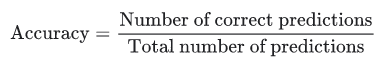

A métrica de Precisão responde a seguinte pergunta: 'Qual a proporção de indentificação positiva estava realmente correta?'

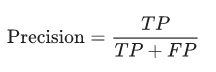

Já Recall busca responder: 'Qual proporção de positivos reais foi indetificado corretamente?'

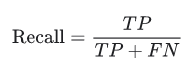

Além de computar essas medidas, será gerado a curva ROC com a média dos valores obtidos na validação cruzada (K-Fold).
A curva ROC ou AUC-ROC ilustra o desempenho de um classificador binário e quanto maior for nossa área debaixo da curva (AUC) melhor é modelo. Ela será usada para comparar os modelos ao final dos experimentos.

Fonte: https://developers.google.com/machine-learning/crash-course/classification

##Naive Bayes
Classificadores Naive Bayes são baseados em uma equação que descreve a relação de probabilidade condicional de grandezas estatísticas. Na classificação bayesiana, estamos interessados ​​em encontrar a probabilidade de um rótulo dadas algumas características observadas, que pode ser escrito por P (classe | dados). Para calcular diretamente usamos: 

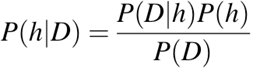

Como os classificadores Naive Bayes fazem suposições rigorosas sobre os dados, eles geralmente não terão um desempenho tão bom quanto um modelo mais complexo. Naive Bayes costuma ser uma boa escolha como uma classificação de linha de base inicial e tem as seguintes vantagens:
- Eles são extremamente rápidos para treinamento e previsão;
- Eles fornecem uma previsão probabilística direta;
- Muitas vezes são facilmente interpretáveis;
- Eles têm muito poucos (se houver) parâmetros ajustáveis.

Os classificadores Naive Bayes tendem a ter um desempenho interessante nas seguintes situações: 
1.  Quando suposições naive realmente correspondem aos dados (muito raro na prática);
2.  Para categorias muito bem separadas, quando a complexidade do modelo é menos importante;
3.  Para dados dimensionais muito altos, quando a complexidade do modelo é menos importante.

Os dois últimos pontos parecem distintos, mas na verdade estão relacionados: à medida que a dimensão de um conjunto de dados aumenta, é muito menos provável que quaisquer dois pontos sejam encontrados próximos (afinal, eles devem estar próximos em todas as dimensões para serem próximos em geral). Isso significa que clusters em dimensões altas tendem a ser mais separados, em média, do que clusters em dimensões baixas, supondo que as novas dimensões realmente adicionem informações. Por esta razão, classificadores simplistas como Naive Bayes  tendem a funcionar tão bem ou melhor do que classificadores mais complexos conforme a dimensionalidade aumenta: uma vez que você tenha dados suficientes, até mesmo um modelo simples pode ser muito poderoso.

Fonte: https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb#scrollTo=hEHUeUhXFlaS

Fonte: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

Para o experimento utiliza-se o método GaussianNB da bilbioteca sklearn.

Na análise, a Precisão foi menor que o Recall.
Isso significa que a fração de instâncias recuperadas e que são relevantes, foram menor que a fração de instâncias relevantes recuperadas totais.
A Acurácia demonstrou uma performance mediana do modelo.
Analisando a curva ROC, observa-se que a AUC foi de 0,94, o que indica um bom classificador para nosso problema.

Mean Accuracy:  0.9655364455364456
Mean Precision:  0.9535281385281384
Mean Recall:  0.9564106806963949


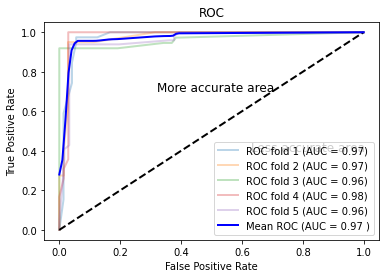

In [ ]:
from sklearn.naive_bayes import GaussianNB
from scipy import interp
from sklearn.metrics import roc_curve,auc

gnb = GaussianNB()

acurracies_NB = []
precisions_NB = []
recalls_NB = []

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train_indices, test_indices in kf.split(X):
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]
  proba_ = gnb.fit(X_train, y_train.ravel()).predict_proba(X_test)

  #proba_ = gnb.fit(X_train, y_train.ravel()).predict_proba(X_test)

  y_preds_train = gnb.predict(X_train)
  y_preds_test = gnb.predict(X_test)

  acurracies_NB.append(accuracy_score(y_test, y_preds_test))
  precisions_NB.append(precision_score(y_test, y_preds_test))
  recalls_NB.append(recall_score(y_test, y_preds_test))

  fpr, tpr, t = metrics.roc_curve(y[test_indices], proba_[:, 1])
  tprs.append(interp(mean_fpr, fpr, tpr))
  roc_auc = auc(fpr, tpr)
  aucs.append(roc_auc)
  plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
  i= i+1

print("Mean Accuracy: ", np.mean(acurracies_NB))
print("Mean Precision: ", np.mean(precisions_NB))
print("Mean Recall: ", np.mean(recalls_NB))

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

# **Decision Tree**

Uma árvore de decisão é uma estrutura de árvore semelhante a um fluxograma em que um nó interno representa o recurso (ou atributo), a ramificação representa uma regra de decisão e cada nó folha representa o resultado. O nó superior em uma árvore de decisão é conhecido como nó raiz.

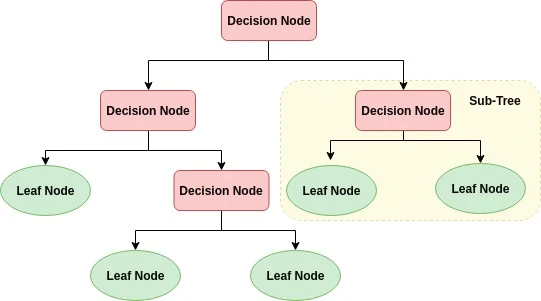

A ideia por traz do Algoritimo é bastante simples e funciona conforme os passos a seguir:

1.  Seleciona o melhor atributo para dividir os dados usando [Attribute Selection Measures](http://www.mgcub.ac.in/pdf/material/2020041815334989a585e9d6.pdf);
2.  Torna esse atributo um nó de decisão e divide o conjunto de dados em subconjuntos menores;
3.  Inicia o processo de construção da árvore repetindo este processo recursivamente para cada filho até que uma das condições abaixo seja alcançada:
  -  Todas as tuplas pertencem ao mesmo valor de atributo;
  -  Não já mais atributos restantes;
  -  Não há mais insâncias.

O algoritmo recebe alguns hiperparametros que podem ajudar a evoluir o modelo. O mais importante é a profundidade máxima da nossa árvore de decisão. Ele indica qual a profundidade máxima da nossa árvore, também pode ser descrito como o comprimento do caminho mais longo entre a raiz e uma folha.

Para o experimento realiza-se 5 testes variando a profundidade máxima da árvore. No primeiro teste considera-se uma profundidade dita "infinita" representada por 'None' e em seguida varia-se de 100 a 400 com um salto de 100.

Logo em seguida representa-se graficamente os resultados.

Em todos os testes realizados na Árvore de Decisão foi verificado que as três métricas (Precisão, Recall e Acurácia) medidas ficaram ácima de 90%, portanto a variação da profundidade da árvore não impacta no resultado final do Dataset.
Isso significa que a fração de instâncias recuperadas e que são relevantes, foram maior que a fração de instâncias relevantes recuperadas totais.
A AUC média em todos os testes foi de 0,94, o que indica que a variação do hiperparametros de densidade testada não gerou melhorias ou pioras no modelo.

Fonte: https://www.datacamp.com/community/tutorials/decision-tree-classification-python

Fonte: https://infocenter.informationbuilders.com/wf80/index.jsp?topic=%2Fpubdocs%2FRStat16%2Fsource%2Ftopic47.htm

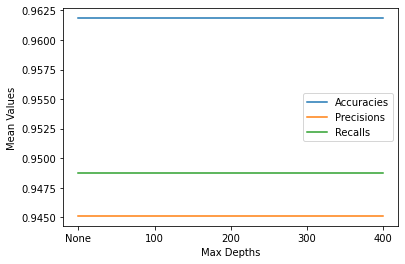

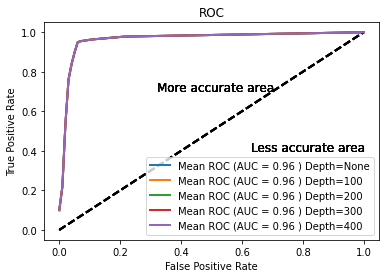

In [ ]:
from sklearn import tree


acurracies_DTNone = []
acurracies_DT100 = []
acurracies_DT200 = []
acurracies_DT300 = []
acurracies_DT400 = []

precisions_DTNone = []
precisions_DT100 = []
precisions_DT200 = []
precisions_DT300 = []
precisions_DT400 = []

recalls_DTNone = []
recalls_DT100 = []
recalls_DT200 = []
recalls_DT300 = []
recalls_DT400 = []

tprsDTNone = []
aucsDTNone = []
mean_fprDTNone = np.linspace(0,1,100)

tprsDT100 = []
aucsDT100 = []
mean_fprDT100 = np.linspace(0,1,100)

tprsDT200 = []
aucsDT200 = []
mean_fprDT200 = np.linspace(0,1,100)

tprsDT300 = []
aucsDT300 = []
mean_fprDT300 = np.linspace(0,1,100)

tprsDT400 = []
aucsDT400 = []
mean_fprDT400 = np.linspace(0,1,100)

for train_indices, test_indices in kf.split(X):
  #print("Fold", len(acurracies_DTNone)+1)
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  best_accuracy = 0
  max = 0
  for max in range(5):
    if max == 0:
      max = None
    else:
      max = max*100
    tree_reg = tree.DecisionTreeClassifier(max_depth=max)
    tree_reg.fit(X_train, y_train)

    y_preds_train = tree_reg.predict(X_train)
    y_preds_test = tree_reg.predict(X_test)

    y_score = tree_reg.score(X_test, y_test)

    if max == None:
      acurracies_DTNone.append(accuracy_score(y_test, y_preds_test))
      precisions_DTNone.append(precision_score(y_test, y_preds_test))
      recalls_DTNone.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, tree_reg.predict_proba(X_test)[:, 1])
      tprsDTNone.append(interp(mean_fprDTNone, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsDTNone.append(roc_auc)
    elif max == 100:
      acurracies_DT100.append(accuracy_score(y_test, y_preds_test))
      precisions_DT100.append(precision_score(y_test, y_preds_test))
      recalls_DT100.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, tree_reg.predict_proba(X_test)[:, 1])
      tprsDT100.append(interp(mean_fprDT100, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsDT100.append(roc_auc)
    elif max == 200:
      acurracies_DT200.append(accuracy_score(y_test, y_preds_test))
      precisions_DT200.append(precision_score(y_test, y_preds_test))
      recalls_DT200.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, tree_reg.predict_proba(X_test)[:, 1])
      tprsDT200.append(interp(mean_fprDT200, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsDT200.append(roc_auc)
    elif max == 300:
      acurracies_DT300.append(accuracy_score(y_test, y_preds_test))
      precisions_DT300.append(precision_score(y_test, y_preds_test))
      recalls_DT300.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, tree_reg.predict_proba(X_test)[:, 1])
      tprsDT300.append(interp(mean_fprDT300, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsDT300.append(roc_auc)
    else:
      acurracies_DT400.append(accuracy_score(y_test, y_preds_test))
      precisions_DT400.append(precision_score(y_test, y_preds_test))
      recalls_DT400.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, tree_reg.predict_proba(X_test)[:, 1])
      tprsDT400.append(interp(mean_fprDT400, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsDT400.append(roc_auc)

plt.plot(["None", 100, 200, 300, 400], [np.mean(acurracies_DTNone), np.mean(acurracies_DT100), np.mean(acurracies_DT200), np.mean(acurracies_DT300), np.mean(acurracies_DT400)], label="Accuracies")
plt.plot(["None", 100, 200, 300, 400], [np.mean(precisions_DTNone), np.mean(precisions_DT100), np.mean(precisions_DT200), np.mean(precisions_DT300), np.mean(precisions_DT400)], label= "Precisions")
plt.plot(["None", 100, 200, 300, 400], [np.mean(recalls_DTNone), np.mean(recalls_DT100), np.mean(recalls_DT200), np.mean(recalls_DT300), np.mean(recalls_DT400)], label="Recalls")
plt.xlabel("Max Depths")
plt.ylabel("Mean Values")
plt.legend()
plt.show()

for i in ['None', '100', '200', '300', '400']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprsDT" + i], axis=0)
  mean_auc = auc(locals()["mean_fprDT" + i], mean_tpr)
  plt.plot(locals()["mean_fprDT" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) Depth=%s' % (mean_auc, i),lw=2, alpha=1)
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)

plt.show()


##**SVM**

Geralmente, Support Vector Machines é considerado uma abordagem de classificação, mas pode ser empregado em ambos os tipos de problemas de classificação e regressão. Ele pode lidar facilmente com várias variáveis ​​contínuas e categóricas. SVM constrói um hiperplano no espaço multidimensional para separar diferentes classes (no nosso caso CONFIRMED e FALSE POSITIVE). O SVM gera o hiperplano ideal de maneira iterativa, que é usado para minimizar um erro. A ideia central do SVM é encontrar um hiperplano marginal máximo (MMH) que melhor divide o conjunto de dados em classes.

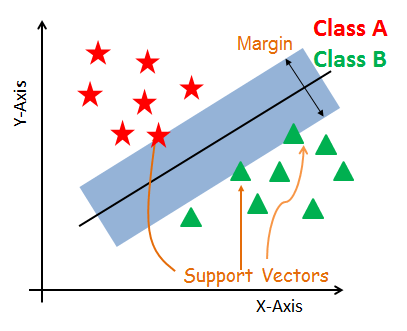

O objetivo principal é segregar o conjunto de dados fornecido da melhor maneira possível. A distância entre os pontos mais próximos é conhecida como margem. O objetivo é selecionar um hiperplano com a máxima margem possível entre os vetores de suporte no conjunto de dados fornecido. O SVM procura o hiperplano marginal máximo nas seguintes etapas:

1.  Gerar hiperplanos que segregam as classes da melhor maneira;
2.  Selecione o hiperplano direito com a segregação máxima dos pontos de dados mais próximos.

O algoritmo SVM é implementado na prática usando um kernel. Um kernel transforma um espaço de dados de entrada na forma necessária. O SVM usa uma técnica chamada truque do kernel. Aqui, o kernel pega um espaço de entrada de baixa dimensão e o transforma em um espaço de dimensão superior. Em outras palavras, você pode dizer que ele converte problemas não separáveis ​​em problemas separáveis, adicionando mais dimensão a eles. É mais útil em problemas de separação não linear. O truque do kernel o ajuda a construir um classificador mais preciso.O algoritmo SVM é implementado na prática usando um kernel. Um kernel transforma um espaço de dados de entrada na forma necessária. O SVM usa uma técnica chamada truque do kernel. Aqui, o kernel pega um espaço de entrada de baixa dimensão e o transforma em um espaço de dimensão superior. Em outras palavras, você pode dizer que ele converte problemas não separáveis ​​em problemas separáveis, adicionando mais dimensão a eles. É mais útil em problemas de separação não linear. O truque do kernel o ajuda a construir um classificador mais preciso.

No experimento avalia-se os diferentes kernels do SVM:

- **Linear**: Pode ser usado como produto escalar normal de quaisquer duas observações fornecidas, para melhorar o tempo de processamento o número máximo de iterações foi limitado a 1000;
- **Sigmoid**: É equivalente a uma rede neural perceptron de duas camadas;
- **Polinomial**: É uma forma mais generalizada do Linear, ele pode distinguir espaço de entrada curvo ou não linear;
- **Radial Basis Function (RBF)**: É usada para mapear um espaço de entrada em um espaço dimensional infinito.

Avaliando os kernels testados o que obteve maiores valores de Precisão, Recall e Acurácia foi o kernel Linear, indicando que o kernel Linear é o mais adequado para classificar o Dataset.
Esse resultado pode ser confirmado pela curva ROC obtida do modelo, onde mostra claramento o melhor resultado do Kernel Linear em relação aos demais (AUC = 0,96)

Fonte: https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

Fonte: http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/

Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


Mean Accuracy linear:  0.9655692055692056
Mean Accuracy sigmoid:  0.5969696969696969
Mean Accuracy poly:  0.9655692055692056
Mean Accuracy rbf:  0.9655692055692056 

Mean Precision linear:  0.9537465893279847
Mean Precision sigmoid:  0.4676800614844093
Mean Precision poly:  0.9537465893279847
Mean Precision rbf:  0.9537465893279847 

Mean Recall linear:  0.9565617715617716
Mean Recall sigmoid:  0.5160722610722611
Mean Recall poly:  0.9565617715617716
Mean Recall rbf:  0.9565617715617716 



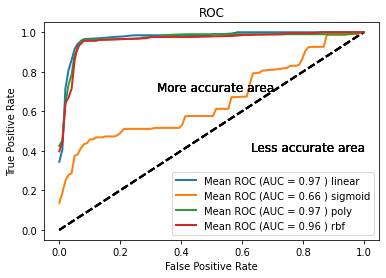

In [ ]:
from sklearn import svm
from datetime import datetime
from sklearn.calibration import CalibratedClassifierCV

acurracies_SVM_linear = []
acurracies_SVM_sigmoid = []
acurracies_SVM_poly = []
acurracies_SVM_rbf = []

precisions_SVM_linear = []
precisions_SVM_sigmoid = []
precisions_SVM_poly = []
precisions_SVM_rbf = []

recalls_SVM_linear = []
recalls_SVM_sigmoid = []
recalls_SVM_poly = []
recalls_SVM_rbf = []

tprs_linear = []
aucs_linear = []
mean_fpr_linear = np.linspace(0,1,100)

tprs_sigmoid = []
aucs_sigmoid = []
mean_fpr_sigmoid = np.linspace(0,1,100)

tprs_poly = []
aucs_poly = []
mean_fpr_poly = np.linspace(0,1,100)

tprs_rbf = []
aucs_rbf = []
mean_fpr_rbf = np.linspace(0,1,100)

for train_indices, test_indices in kf.split(X):
  #print("Fold", len(acurracies_SVM_linear)+1)
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  for kernel in ('linear', 'sigmoid', 'poly', 'rbf'):
    #print(kernel)
    #now = datetime.now()
    #current_time = now.strftime("%H:%M:%S")
    #print("Current Time =", current_time)
    clf = svm.SVC(kernel=kernel, gamma='scale', probability=True, class_weight='balanced')
    if kernel == 'linear':
      clf = svm.LinearSVC(max_iter=1000)
      clf = CalibratedClassifierCV(clf) 
    clf.fit(X_train, y_train.ravel())

    y_preds_train = clf.predict(X_train)
    y_preds_test = clf.predict(X_test)

    y_score = clf.score(X_test, y_test)

    #print("Accuracy: ", y_score, "\n")
    if kernel == 'linear':
      acurracies_SVM_linear.append(accuracy_score(y_test, y_preds_test))
      precisions_SVM_linear.append(precision_score(y_test, y_preds_test))
      recalls_SVM_linear.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_linear.append(interp(mean_fpr_linear, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_linear.append(roc_auc)
    elif kernel == 'sigmoid':
      acurracies_SVM_sigmoid.append(accuracy_score(y_test, y_preds_test))
      precisions_SVM_sigmoid.append(precision_score(y_test, y_preds_test))
      recalls_SVM_sigmoid.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_sigmoid.append(interp(mean_fpr_sigmoid, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_sigmoid.append(roc_auc)
    elif kernel == 'poly':
      acurracies_SVM_poly.append(accuracy_score(y_test, y_preds_test))
      precisions_SVM_poly.append(precision_score(y_test, y_preds_test))
      recalls_SVM_poly.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_poly.append(interp(mean_fpr_poly, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_poly.append(roc_auc)
    else:
      acurracies_SVM_rbf.append(accuracy_score(y_test, y_preds_test))
      precisions_SVM_rbf.append(precision_score(y_test, y_preds_test))
      recalls_SVM_rbf.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_rbf.append(interp(mean_fpr_rbf, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_rbf.append(roc_auc)
      
  #acurracies_NB.append(y_score)

print("Mean Accuracy linear: ", np.mean(acurracies_SVM_linear))
print("Mean Accuracy sigmoid: ", np.mean(acurracies_SVM_sigmoid))
print("Mean Accuracy poly: ", np.mean(acurracies_SVM_poly))
print("Mean Accuracy rbf: ", np.mean(acurracies_SVM_rbf), "\n")

print("Mean Precision linear: ", np.mean(precisions_SVM_linear))
print("Mean Precision sigmoid: ", np.mean(precisions_SVM_sigmoid))
print("Mean Precision poly: ", np.mean(precisions_SVM_poly))
print("Mean Precision rbf: ", np.mean(precisions_SVM_rbf), "\n")

print("Mean Recall linear: ", np.mean(recalls_SVM_linear))
print("Mean Recall sigmoid: ", np.mean(recalls_SVM_sigmoid))
print("Mean Recall poly: ", np.mean(recalls_SVM_poly))
print("Mean Recall rbf: ", np.mean(recalls_SVM_rbf), "\n")

for i in ['linear', 'sigmoid', 'poly', 'rbf']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprs_" + i], axis=0)
  mean_auc = auc(locals()["mean_fpr_" + i], mean_tpr)
  plt.plot(locals()["mean_fpr_" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) %s' % (mean_auc, i),lw=2, alpha=1)
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)

plt.show()

# **k-NN**

K-NN é um algoritmo de aprendizagem não paramétrico e preguiçoso. Não paramétrico significa que não há nenhuma suposição para a distribuição de dados subjacente. Em outras palavras, a estrutura do modelo é determinada a partir do conjunto de dados. Isso será muito útil na prática, onde a maioria dos conjuntos de dados do mundo real não segue suposições teóricas matemáticas. O algoritmo preguiçoso significa que não precisa de nenhum ponto de dados de treinamento para a geração do modelo. Todos os dados de treinamento usados ​​na fase de teste. Isso torna o treinamento mais rápido e a fase de teste mais lenta e cara. Fase de teste cara significa tempo e memória. Na pior das hipóteses, k-NN precisa de mais tempo para verificar todos os pontos de dados e isso exigirá mais memória para armazenar dados de treinamento.

Em k-NN, k é o número de vizinhos mais próximos. O número de vizinhos é o principal fator decisivo. K é geralmente um número ímpar se o número de classes for 2. Quando K = 1, o algoritmo é conhecido como o algoritmo do vizinho mais próximo. Este é o caso mais simples. Suponha que P1 seja o ponto para o qual o rótulo precisa prever. Primeiro, você encontra o ponto mais próximo de P1 e, em seguida, o rótulo do ponto mais próximo atribuído a P1.

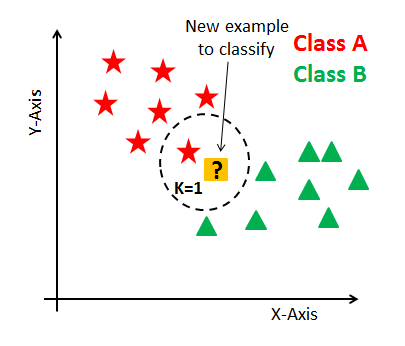

Ele segue basicamento o seguinte passo:

1.  Cálcula a distância;
2.  Encontra o vizinho mais próximo;
3.  Vota para rótulos.

O hiperparâmetro mais importante desse algoritmo é o k (número de vizinhos). K pode ser pensado como uma variavel de controle para o modelo de previsão.

No experimento varia-se o número de vizinhos, indo de 1 até 5 e em seguida plota-se graficamente a Precisão, Recall e Acurácia de cada um dos testes.

O KNN obteve resultados inferiores aos demais modelos comparados (nenhuma das métricas ultrapassou 90%). Este resultado pode ser devido a grande quantidade de features e baixo número de registro no Dataset. Para o KNN, quanto mais features mais registros são necessários.
Quando a curva ROC é análisada, consegue-se notar que o melhor resultado foi obtida com k = 5 (AUC = 0,86). Testes com k ácima de 5 foram realizados, porém o resultado de AUC não obteve melhorias, o que indica que k = 5 seria o melhor para este modelo.

Fonte: https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn


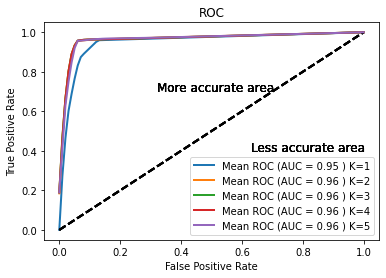

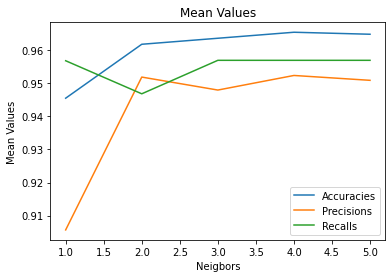

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

acurracies_KNN1  = []
acurracies_KNN2  = []
acurracies_KNN3  = []
acurracies_KNN4  = []
acurracies_KNN5  = []

precisions_KNN1  = []
precisions_KNN2  = []
precisions_KNN3  = []
precisions_KNN4  = []
precisions_KNN5  = []

recalls_KNN1  = []
recalls_KNN2  = []
recalls_KNN3  = []
recalls_KNN4  = []
recalls_KNN5  = []

tprsKNN1 = []
aucsKNN1 = []
mean_fprKNN1 = np.linspace(0,1,100)

tprsKNN2 = []
aucsKNN2 = []
mean_fprKNN2 = np.linspace(0,1,100)

tprsKNN3 = []
aucsKNN3 = []
mean_fprKNN3 = np.linspace(0,1,100)

tprsKNN4 = []
aucsKNN4 = []
mean_fprKNN4 = np.linspace(0,1,100)

tprsKNN5 = []
aucsKNN5 = []
mean_fprKNN5 = np.linspace(0,1,100)

#fig, axs = plt.subplots(6)

for train_indices, test_indices in kf.split(X):
  #print("Fold", len(acurracies_KNN1)+1)
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  for n_neighbors in range(10):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors+1)
    proba_ = neigh.fit(X_train, y_train.ravel()).predict_proba(X_test)

    y_preds_train = neigh.predict(X_train)
    y_preds_test = neigh.predict(X_test)

    y_score = neigh.score(X_test, y_test)

    #print("Accuracy: ", y_score, "\n")
    if n_neighbors == 0:
      acurracies_KNN1.append(accuracy_score(y_test, y_preds_test))
      precisions_KNN1.append(precision_score(y_test, y_preds_test))
      recalls_KNN1.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y[test_indices], proba_[:, 1])
      tprsKNN1.append(interp(mean_fprKNN1, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsKNN1.append(roc_auc)
      #plt.figure(1)
      #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(acurracies_KNN1)+1, roc_auc))
    elif n_neighbors == 1:
      acurracies_KNN2.append(accuracy_score(y_test, y_preds_test))
      precisions_KNN2.append(precision_score(y_test, y_preds_test))
      recalls_KNN2.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y[test_indices], proba_[:, 1])
      tprsKNN2.append(interp(mean_fprKNN2, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsKNN2.append(roc_auc)
      #plt.figure(2)
      #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(acurracies_KNN1)+1, roc_auc))
    elif n_neighbors == 2:
      acurracies_KNN3.append(accuracy_score(y_test, y_preds_test))
      precisions_KNN3.append(precision_score(y_test, y_preds_test))
      recalls_KNN3.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y[test_indices], proba_[:, 1])
      tprsKNN3.append(interp(mean_fprKNN3, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsKNN3.append(roc_auc)
      #plt.figure(3)
      #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(acurracies_KNN1)+1, roc_auc))
    elif n_neighbors == 3:
      acurracies_KNN4.append(accuracy_score(y_test, y_preds_test))
      precisions_KNN4.append(precision_score(y_test, y_preds_test))
      recalls_KNN4.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y[test_indices], proba_[:, 1])
      tprsKNN4.append(interp(mean_fprKNN4, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsKNN4.append(roc_auc)
      #plt.figure(4)
      #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(acurracies_KNN1)+1, roc_auc))
    else:
      acurracies_KNN5.append(accuracy_score(y_test, y_preds_test))
      precisions_KNN5.append(precision_score(y_test, y_preds_test))
      recalls_KNN5.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y[test_indices], proba_[:, 1])
      tprsKNN5.append(interp(mean_fprKNN5, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucsKNN5.append(roc_auc)
      #plt.figure(5)
      #plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (len(acurracies_KNN1)+1, roc_auc))

#print("Mean Accuracy 1 Neigbor: ", np.mean(acurracies_KNN1), "\n")
#print("Mean Accuracy 2 Neigbors: ", np.mean(acurracies_KNN2), "\n")
#print("Mean Accuracy 3 Neigbors: ", np.mean(acurracies_KNN3), "\n")
#print("Mean Accuracy 4 Neigbors: ", np.mean(acurracies_KNN4), "\n")
#print("Mean Accuracy 5 Neigbors: ", np.mean(acurracies_KNN5), "\n")
#print("Mean Accuracy 6 Neigbors: ", np.mean(acurracies_KNN6), "\n")
#print("Mean Accuracy 7 Neigbors: ", np.mean(acurracies_KNN7), "\n")
#print("Mean Accuracy 8 Neigbors: ", np.mean(acurracies_KNN8), "\n")
#print("Mean Accuracy 9 Neigbors: ", np.mean(acurracies_KNN9), "\n")
#print("Mean Accuracy 10 Neigbors: ", np.mean(acurracies_KNN10), "\n")

for i in range(5):
  #plt.figure(i)
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprsKNN" + str(i + 1)], axis=0)
  mean_auc = auc(locals()["mean_fprKNN" + str(i +1)], mean_tpr)
  plt.plot(locals()["mean_fprKNN" + str(i +1)], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) K=%d' % (mean_auc,(i+1)),lw=2, alpha=1)
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)

plt.show()

#plt.figure(6)
plt.plot([1, 2, 3, 4, 5], [np.mean(acurracies_KNN1), np.mean(acurracies_KNN2), np.mean(acurracies_KNN3), np.mean(acurracies_KNN4), np.mean(acurracies_KNN5)], label="Accuracies")
plt.plot([1, 2, 3, 4, 5], [np.mean(precisions_KNN1), np.mean(precisions_KNN2), np.mean(precisions_KNN3), np.mean(precisions_KNN4), np.mean(precisions_KNN5)], label= "Precisions")
plt.plot([1, 2, 3, 4, 5], [np.mean(recalls_KNN1), np.mean(recalls_KNN2), np.mean(recalls_KNN3), np.mean(recalls_KNN4), np.mean(recalls_KNN5)], label="Recalls")
plt.xlabel("Neigbors")
plt.ylabel("Mean Values")
plt.title('Mean Values')
plt.legend()
plt.show()


# **Random Forest**

O Radom Forest pode ser exlicado como um conjunto de Árvore de Decisão, onde que no final de cada classificação das árvores, o resultado mais votado é o previsto.

Funciona com os seguintes passos:

1.  Selecionar amostras aleatórias do conjunto de dados;
2.  Construir uma árvore de decisão para cada amostra selecionada;
3.  Executar uma votação para cada resultado previsto;
4.  Selecionar o resultado mais votado.

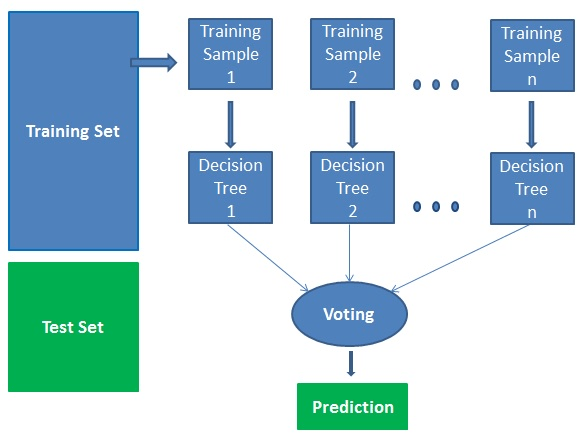

O hiperparâmetro mais importante é a quantidade de árvores que teremos no nosso modelo. Isso vai delimitar a quantidade de votos que teremos e isso é decisivo na nossa classificação.

Para o experimento iremos variar o número de árvores de 10 até 50 com o salto de 10. Em seguida o gráfico de Precisão, Recall e Acrurácia será plotado.

Na análise, a Precisão foi maior que o Recall em todos os testes.
Isso significa que a fração de instâncias recuperadas e que são relevantes, foram maior que a fração de instâncias relevantes recuperadas totais.
Nota-se que todos as métricas avaliadas ficaram ácima de 90%.
Analisando a curva ROC nota-se o resultado de AUC igual a 0,99 para todos os testes realizados, o que indica que o aumento do número de árvores não traz melhorias para o modelo, a quantidade de número 10 seria suficiente para um bom modelo e bom tempo de processamento.

Fonte: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

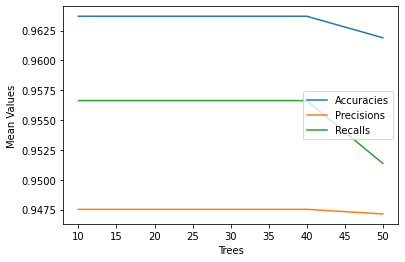

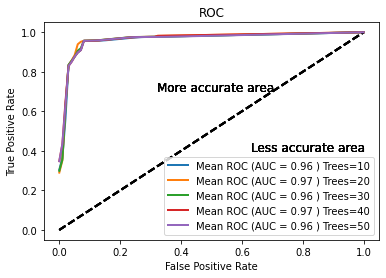

In [ ]:
from sklearn.ensemble import RandomForestClassifier

acurracies_tree10  = []
acurracies_tree20  = []
acurracies_tree30  = []
acurracies_tree40  = []
acurracies_tree50  = []

precisions_tree10  = []
precisions_tree20  = []
precisions_tree30  = []
precisions_tree40  = []
precisions_tree50  = []

recalls_tree10  = []
recalls_tree20  = []
recalls_tree30  = []
recalls_tree40  = []
recalls_tree50  = []

tprs_tree10 = []
aucs_tree10 = []
mean_fpr_tree10 = np.linspace(0,1,100)

tprs_tree20 = []
aucs_tree20 = []
mean_fpr_tree20 = np.linspace(0,1,100)

tprs_tree30 = []
aucs_tree30 = []
mean_fpr_tree30 = np.linspace(0,1,100)

tprs_tree40 = []
aucs_tree40 = []
mean_fpr_tree40 = np.linspace(0,1,100)

tprs_tree50 = []
aucs_tree50 = []
mean_fpr_tree50 = np.linspace(0,1,100)

for train_indices, test_indices in kf.split(X):
  #print("Fold", len(acurracies_tree10)+1)
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  for n_trees in range(5):
    forest_reg = RandomForestClassifier(n_estimators=(n_trees+1)*10)
    forest_reg.fit(X_train, y_train.ravel())

    y_preds_train = forest_reg.predict(X_train)
    y_preds_test = forest_reg.predict(X_test)

    y_score = forest_reg.score(X_test, y_test)

    if n_trees == 0:
      acurracies_tree10.append(accuracy_score(y_test, y_preds_test))
      precisions_tree10.append(precision_score(y_test, y_preds_test))
      recalls_tree10.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, forest_reg.predict_proba(X_test)[:, 1])
      tprs_tree10.append(interp(mean_fpr_tree10, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_tree10.append(roc_auc)
    elif n_trees == 1:
      acurracies_tree20.append(accuracy_score(y_test, y_preds_test))
      precisions_tree20.append(precision_score(y_test, y_preds_test))
      recalls_tree20.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, forest_reg.predict_proba(X_test)[:, 1])
      tprs_tree20.append(interp(mean_fpr_tree20, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_tree20.append(roc_auc)
    elif n_trees == 2:
      acurracies_tree30.append(accuracy_score(y_test, y_preds_test))
      precisions_tree30.append(precision_score(y_test, y_preds_test))
      recalls_tree30.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, forest_reg.predict_proba(X_test)[:, 1])
      tprs_tree30.append(interp(mean_fpr_tree30, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_tree30.append(roc_auc)
    elif n_trees == 3:
      acurracies_tree40.append(accuracy_score(y_test, y_preds_test))
      precisions_tree40.append(precision_score(y_test, y_preds_test))
      recalls_tree40.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, forest_reg.predict_proba(X_test)[:, 1])
      tprs_tree40.append(interp(mean_fpr_tree40, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_tree40.append(roc_auc)
    else:
      acurracies_tree50.append(accuracy_score(y_test, y_preds_test))
      precisions_tree50.append(precision_score(y_test, y_preds_test))
      recalls_tree50.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, forest_reg.predict_proba(X_test)[:, 1])
      tprs_tree50.append(interp(mean_fpr_tree50, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_tree50.append(roc_auc)

plt.plot([10, 20, 30, 40, 50], [np.mean(acurracies_tree10), np.mean(acurracies_tree20), np.mean(acurracies_tree30), np.mean(acurracies_tree40), np.mean(acurracies_tree50)], label="Accuracies")
plt.plot([10, 20, 30, 40, 50], [np.mean(precisions_tree10), np.mean(precisions_tree20), np.mean(precisions_tree30), np.mean(precisions_tree40), np.mean(precisions_tree50)], label= "Precisions")
plt.plot([10, 20, 30, 40, 50], [np.mean(recalls_tree10), np.mean(recalls_tree20), np.mean(recalls_tree30), np.mean(recalls_tree40), np.mean(recalls_tree50)], label="Recalls")
plt.xlabel("Trees")
plt.ylabel("Mean Values")
plt.legend()
plt.show()

for i in ['10', '20', '30', '40', '50']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprs_tree" + i], axis=0)
  mean_auc = auc(locals()["mean_fpr_tree" + i], mean_tpr)
  plt.plot(locals()["mean_fpr_tree" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) Trees=%s' % (mean_auc, i),lw=2, alpha=1)
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)

plt.show()



# **Gradient Tree Boosting**

Esse modelo parte da construção de Árvore de Decisão e a iteração entre elas. Ele parte de uma predição inicial e constroi a primeira árvore de decisão, após o resultado dessa primeira árvore, ele é multiplicado por um Learning Rate que então cria-se a segunda árvore e o processo de repete até o número máximo de interações selecionado ou até que não exista masi melhorias adicionais.

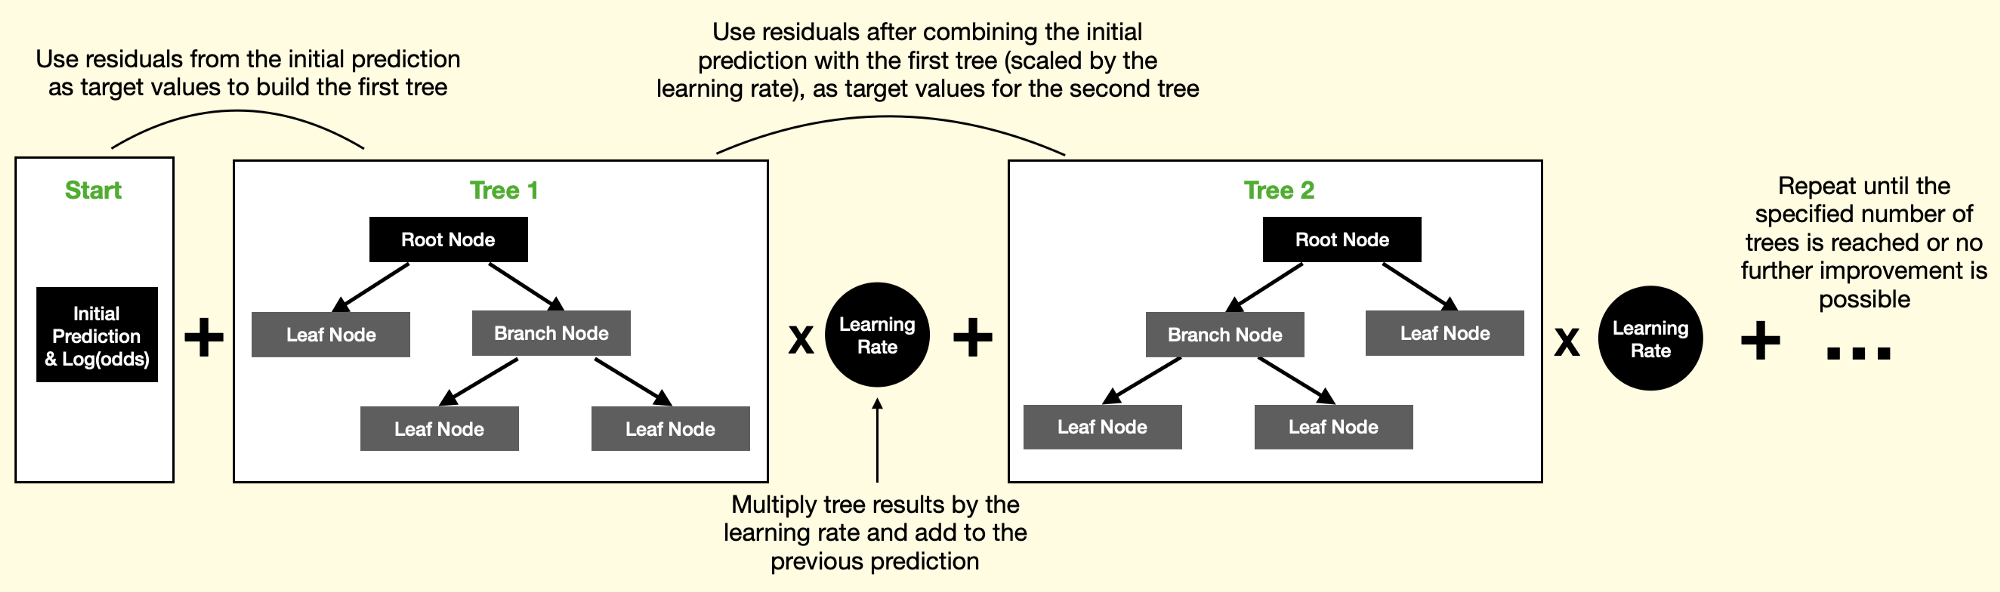

No experimento varia-se o número de iterações de 2 a 10 com um salto de 2 e como os demais métodos plota-se o gráfico de Precisão, Recall e Acurácia.

Nota-se que ácima de 4 iterações os valores de Precisao, Recall e Acurácia ficaram maior que 90 %. Quando a curva ROC é analisada fica claro que a partir de 4, os valores de AUC permanecem os mesmos.


Fonte: https://towardsdatascience.com/gradient-boosted-trees-for-classification-one-of-the-best-machine-learning-algorithms-35245dab03f2

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

acurracies_it2  = []
acurracies_it4  = []
acurracies_it6  = []
acurracies_it8  = []
acurracies_it10  = []

precisions_it2  = []
precisions_it4 = []
precisions_it6  = []
precisions_it8  = []
precisions_it10  = []

recalls_it2  = []
recalls_it4  = []
recalls_it6  = []
recalls_it8 = []
recalls_it10  = []

tprs_it2 = []
aucs_it2 = []
mean_fpr_it2 = np.linspace(0,1,100)

tprs_it4 = []
aucs_it4 = []
mean_fpr_it4 = np.linspace(0,1,100)

tprs_it6 = []
aucs_it6 = []
mean_fpr_it6 = np.linspace(0,1,100)

tprs_it8 = []
aucs_it8 = []
mean_fpr_it8 = np.linspace(0,1,100)

tprs_it10 = []
aucs_it10 = []
mean_fpr_it10 = np.linspace(0,1,100)

for train_indices, test_indices in kf.split(X):
  #print("Fold", len(acurracies_it100)+1)
  X_train, X_test = X[train_indices], X[test_indices]
  y_train, y_test = y[train_indices], y[test_indices]

  for n_it in range(5):
    clf = GradientBoostingClassifier(n_estimators=(n_it+1)*2)
    clf.fit(X_train, y_train.ravel())

    y_preds_train = clf.predict(X_train)
    y_preds_test = clf.predict(X_test)

    y_score = clf.score(X_test, y_test)

    if n_it == 0:
      acurracies_it2.append(accuracy_score(y_test, y_preds_test))
      precisions_it2.append(precision_score(y_test, y_preds_test))
      recalls_it2.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_it2.append(interp(mean_fpr_it2, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_it2.append(roc_auc)
    elif n_it == 1:
      acurracies_it4.append(accuracy_score(y_test, y_preds_test))
      precisions_it4.append(precision_score(y_test, y_preds_test))
      recalls_it4.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_it4.append(interp(mean_fpr_it4, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_it4.append(roc_auc)
    elif n_it == 2:
      acurracies_it6.append(accuracy_score(y_test, y_preds_test))
      precisions_it6.append(precision_score(y_test, y_preds_test))
      recalls_it6.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_it6.append(interp(mean_fpr_it6, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_it6.append(roc_auc)
    elif n_it == 3:
      acurracies_it8.append(accuracy_score(y_test, y_preds_test))
      precisions_it8.append(precision_score(y_test, y_preds_test))
      recalls_it8.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_it8.append(interp(mean_fpr_it8, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_it8.append(roc_auc)
    else:
      acurracies_it10.append(accuracy_score(y_test, y_preds_test))
      precisions_it10.append(precision_score(y_test, y_preds_test))
      recalls_it10.append(recall_score(y_test, y_preds_test))

      fpr, tpr, t = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
      tprs_it10.append(interp(mean_fpr_it10, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs_it10.append(roc_auc)

#plt.plot([2, 4, 6, 8, 10], [np.mean(acurracies_it100), np.mean(acurracies_it200), np.mean(acurracies_it300), np.mean(acurracies_it400), np.mean(acurracies_it500)], label="Accuracies")
plt.plot([2, 4, 6, 8, 10], [np.mean(precisions_it100), np.mean(precisions_it200), np.mean(precisions_it300), np.mean(precisions_it400), np.mean(precisions_it500)], label= "Precisions")
plt.plot([2, 4, 6, 8, 10], [np.mean(recalls_it100), np.mean(recalls_it200), np.mean(recalls_it300), np.mean(recalls_it400), np.mean(recalls_it500)], label="Recalls")
plt.xlabel("Iterations")
plt.ylabel("Mean Values")
plt.legend()
plt.show()

for i in ['2', '4', '6', '8', '10']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprs_it" + i], axis=0)
  mean_auc = auc(locals()["mean_fpr_it" + i], mean_tpr)
  plt.plot(locals()["mean_fpr_it" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) It=%s' % (mean_auc, i),lw=2, alpha=1)
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)

plt.show()


NameError: ignored

# **Conclusions**

A curva ROC de cada experimento pode ser vista a seguir:

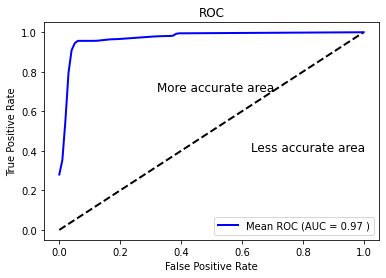

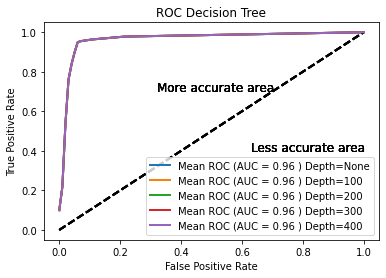

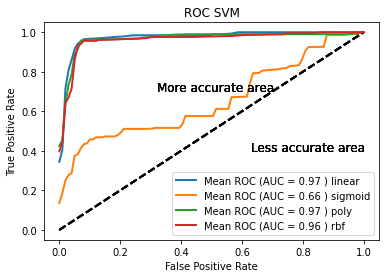

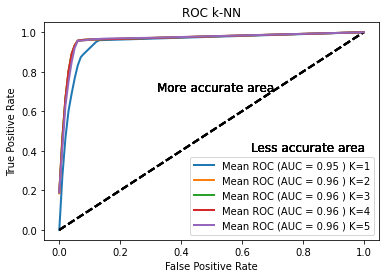

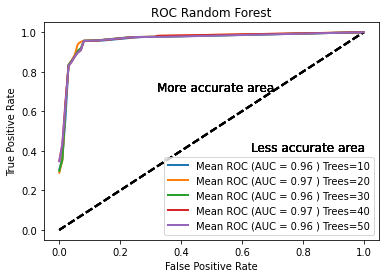

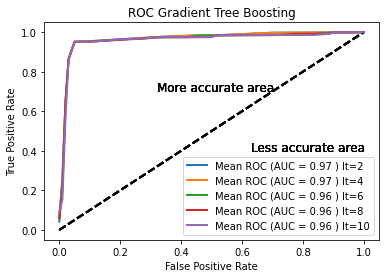

In [ ]:
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

for i in ['None', '100', '200', '300', '400']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprsDT" + i], axis=0)
  mean_auc = auc(locals()["mean_fprDT" + i], mean_tpr)
  plt.plot(locals()["mean_fprDT" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) Depth=%s' % (mean_auc, i),lw=2, alpha=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Decision Tree')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

for i in ['linear', 'sigmoid', 'poly', 'rbf']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprs_" + i], axis=0)
  mean_auc = auc(locals()["mean_fpr_" + i], mean_tpr)
  plt.plot(locals()["mean_fpr_" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) %s' % (mean_auc, i),lw=2, alpha=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC SVM')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

for i in range(5):
  #plt.figure(i)
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprsKNN" + str(i + 1)], axis=0)
  mean_auc = auc(locals()["mean_fprKNN" + str(i +1)], mean_tpr)
  plt.plot(locals()["mean_fprKNN" + str(i +1)], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) K=%d' % (mean_auc,(i+1)),lw=2, alpha=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC k-NN')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

for i in ['10', '20', '30', '40', '50']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprs_tree" + i], axis=0)
  mean_auc = auc(locals()["mean_fpr_tree" + i], mean_tpr)
  plt.plot(locals()["mean_fpr_tree" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) Trees=%s' % (mean_auc, i),lw=2, alpha=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Random Forest')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

for i in ['2', '4', '6', '8', '10']:
  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(locals()["tprs_it" + i], axis=0)
  mean_auc = auc(locals()["mean_fpr_it" + i], mean_tpr)
  plt.plot(locals()["mean_fpr_it" + i], mean_tpr,
         label=r'Mean ROC (AUC = %0.2f ) It=%s' % (mean_auc, i),lw=2, alpha=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Gradient Tree Boosting')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

Fazendo uma análise e classificação baseada na curva ROC ou no valor de AUC, pode-se fazer uma ordem do melhor para o pior classificar em nossos experimentos, a ordem fica da seguinte forma:

1. Random Forest com Trees = 10;
2. Gradient Tree Boosting com It = 4;
3. SVM Linear;
4. Naive Bayes;
5. Decision Tree com Depth = 100;
6. k-NN com k = 5.

Os métodos Naive Bayes e Decision Tree apresentaram o mesmo valor de AUX (0,94), porém Naive Bayes ficou em 4º porque é mais simples de ser implementado quando comparado com Decision Tree.

Abaixo é mostrado os resultados de Acurácia, Precisão e Recal dos melhors modelos apresentados ácima.

In [ ]:
data = {'Random Forest': [np.mean(acurracies_tree10), np.mean(precisions_tree10), np.mean(recalls_tree10)],
        'Gradient Tree Bosting': [np.mean(acurracies_it4), np.mean(precisions_it4), np.mean(recalls_it4)],
        'SVM Linear': [np.mean(acurracies_SVM_linear), np.mean(precisions_SVM_linear), np.mean(recalls_SVM_linear)],
        'Naive Bayes': [np.mean(acurracies_NB), np.mean(precisions_NB), np.mean(recalls_NB)],
        'Decision Tree': [np.mean(acurracies_DT100), np.mean(precisions_DT100), np.mean(recalls_DT100)],
        'k-NN': [np.mean(acurracies_KNN5), np.mean(precisions_KNN5), np.mean(precisions_KNN5)]}

table = pd.DataFrame(data, columns=['Random Forest', 'Gradient Tree Bosting', 'SVM Linear', 'Naive Bayes', 'Decision Tree', 'k-NN'],
                     index = ['Acurácia', 'Precisão', 'Recall'])
table

,Random Forest,Gradient Tree Bosting,SVM Linear,Naive Bayes,Decision Tree,k-NN
Acurácia,0.963702,0.963686,0.965569,0.965536,0.961835,0.964865
Precisão,0.947515,0.952727,0.953747,0.953528,0.945120,0.950925
Recall,0.956631,0.951431,0.956562,0.956411,0.948736,0.950925


Analisando resultados de Precisão e Recall nota-se que os modelos que obtiveram todas as métricas ácima de 90% foram:

- Random Forest;
- Gradient Tree Boosting;
- Decision Tree.

O SVM Linear também obteve um resultado bastante interessante, novos testes com ele podem ser feitos aumentando a quantidade de iterações, provavelmente os resultados serão superiores aos atuais. Porém neste cenário o tempo de processamento é bastante alto. Este teste foi feito e demorou cerca de 2 horas para completar todos os testes da validação cruzada.

O modelo de Naive Bayes apresentou um resultado bem interessante, pois seu método é extremanete simples e tem pouquissimos hiperparâmetros, então ele pode sim ser considerado como um bom classificador.

O k-NN poderia alcançar resultados melhores se exisitsse mais dados de treino, já que para esse método, quanto mais features, mais dados é necessário e nossos dados tinham relativamente poucos registros em comparação com o número de features observadas para o k-NN.